In [2]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io as io
import pylab
import os

In [3]:
import os.path as osp
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from ensemble_boxes import *
import cv2
import copy

from val_ensemble import *

In [4]:
os.chdir("../")

### Validation csv 생성

In [13]:
LABEL_NAME = ["General trash", "Paper", "Paper pack", "Metal", 
              "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

## 원하는 config, checkpoint 경로
config_path = '/opt/ml/detection/main/level2-object-detection-level2-cv-14/mmdetection/configs/atss_swin_l_1024_aug/atss_swin_l_1024_aug.py'
checkpoint_path = '/opt/ml/detection/main/level2-object-detection-level2-cv-14/work_dirs/atss_swin_l_1024_aug/best_bbox_mAP_50_epoch_16.pth'

In [ ]:
# score_thr는 0.001로 고정 (수정 가능)
nms_iou_thr = 0.5

cfg = Config.fromfile(config_path)

cfg.data.test.ann_file = GT_JSON

seed = 42
cfg.gpu_ids = [1]

cfg.data.test.test_mode = True
print(cfg.data.test)

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None
cfg.model.test_cfg['score_thr'] = 0.001
cfg.model.test_cfg['nms'] = dict(type = 'nms', iou_threshold = nms_iou_thr)
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=4,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

output = single_gpu_test(model, data_loader, show_score_thr=0.01) # output 계산

# submission 양식에 맞게 output 후처리
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=img_ids[i]))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.head()

In [10]:
submission.to_csv('ensemble_csv/02.csv', index = False)

### Ensemble

In [5]:
# load ground truth
GT_JSON = 'dataset/val_fold0.json'
with open(GT_JSON, 'r') as outfile:
    test_anno = (json.load(outfile))

In [6]:
## Ensemble
submission_files = ['ensemble_csv/01.csv',
                   'ensemble_csv/02.csv']
submission_df = [pd.read_csv(file) for file in submission_files]

In [7]:
image_ids = submission_df[0]['image_id'].tolist()
coco = COCO(GT_JSON)

cats = coco.loadCats(coco.getCatIds())
classes=[cat['name'] for cat in cats]
imgIds = coco.getImgIds() # image index

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [13]:
prediction_strings = []
file_names = []
# ensemble 시 설정할 iou threshold 
# 수정하면서 실습 하시면 됩니다!
iou_thr = 0.5
skip_box_thr = 0.3
weights = [0.5, 0.5]
# 각 image id 별로 submission file에서 box좌표 추출
for i, image_id in zip(imgIds ,image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
# 각 submission file 별로 prediction box좌표 불러오기
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            # bounding box 좌표값들이 0~1 사이의 값을 가져야 합니다.
            # Order: x1, y1, x2, y2
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
# 예측 box가 있다면 이를 ensemble 수행
# wbf 외에도 다른 ensemble을 사용할 수 있습니다
    if len(boxes_list):
        # boxes, scores, labels = nms(boxes_list, scores_list, labels_list, iou_thr=iou_thr)
        # boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, iou_thr=iou_thr)
        # boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, iou_thr=iou_thr)
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights = weights, iou_thr=iou_thr, skip_box_thr = skip_box_thr)
        
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.head()

pred_df = submission
new_pred = []
file_names = pred_df['image_id'].values.tolist()
bboxes = pred_df['PredictionString'].values.tolist()
    
for i, bbox in enumerate(bboxes):
    if isinstance(bbox, float):
        print(f'{file_names[i]} empty box')

for file_name, bbox in tqdm(zip(file_names, bboxes)):
    boxes = np.array(str(bbox).split(' '))
    
    if len(boxes) % 6 == 1:
        boxes = boxes[:-1].reshape(-1, 6)
    elif len(boxes) % 6 == 0:
        boxes = boxes.reshape(-1, 6)
    else:
        raise Exception('error', 'invalid box count')
    for box in boxes:
        new_pred.append([file_name, box[0], box[1], float(box[2]), float(box[4]), float(box[3]), float(box[5])])
        
gt = []
   
'''
image id 별로 GT 값 추가 (여기서는 test.json을 사용하였기 때문에 GT가 없습니다.)
'''
for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['id'])
    annotation_info_list = coco.loadAnns(annotation_id)
        
    file_name = image_info['file_name']
        
    for annotation in annotation_info_list:
        gt.append([file_name, annotation['category_id'],
                   float(annotation['bbox'][0]),
                   float(annotation['bbox'][0]) + float(annotation['bbox'][2]),
                   float(annotation['bbox'][1]),
                   (float(annotation['bbox'][1]) + float(annotation['bbox'][3]))])   

'''
calculate mAP
'''

_ = mean_average_precision_for_boxes(gt, new_pred, iou_threshold=0.5) 


488it [00:00, 24700.66it/s]

Number of files in annotations: 488
Number of files in predictions: 488
Unique classes: 10
Detections length: 488
Annotations length: 488
General trash | 0.364928 |     328
Paper      | 0.601537 |     620
Paper pack | 0.643567 |      58
Metal      | 0.615621 |      99
Glass      | 0.686128 |     123
Plastic    | 0.482837 |     253
Styrofoam  | 0.640258 |     137
Plastic bag | 0.775011 |     544
Battery    | 0.848765 |      27
Clothing   | 0.690217 |      55
mAP: 0.634887


(-0.5, 1023.5, 1023.5, -0.5)

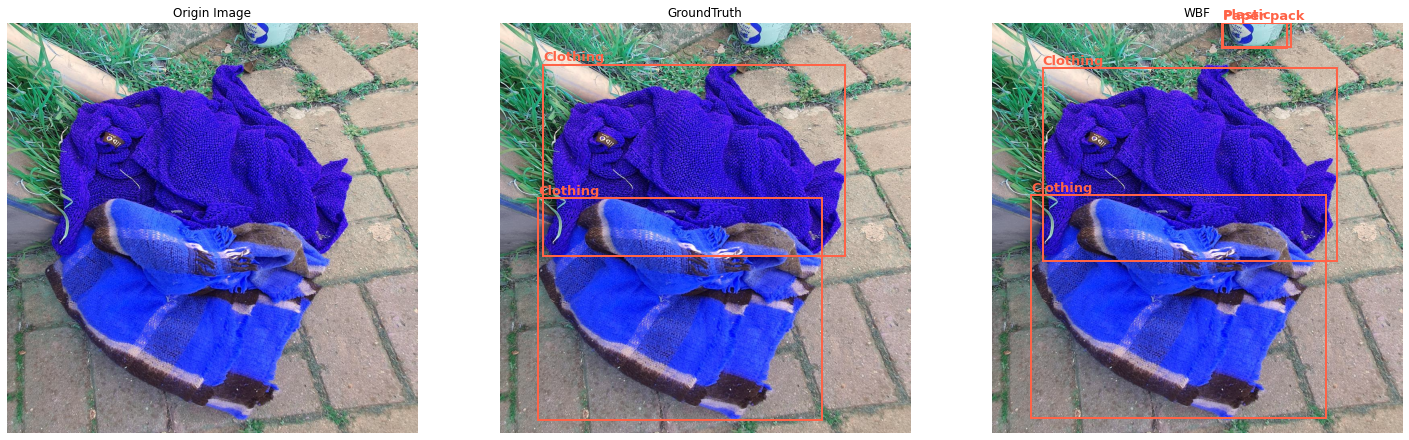

In [16]:
"""
Visualization
"""
data_dir = 'dataset/'

# id range 0 ~ 487
i = 0

img_idx = imgIds[i]
annotation_ids = coco.getAnnIds(imgIds = imgIds[i])
anns = coco.loadAnns(annotation_ids)

img_id = coco.loadImgs(img_idx)[0]['file_name']
img_path=data_dir+ img_id
img = cv2.imread(img_path)

boxes, labels = get_box_label(submission, imgIds[i], img_id, coco)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(25, 14)

# 최대 6개 모델을 앙상블 한다 가정하고 6 색상을 준비했습니다
# 모델을 더 추가해서 확인해 보고 싶으신 분들은 색상을 추가해주시면 됩니다!
color = [(255,0,0),(0,0,255),(255,255,0),(0,255,255),(255,0,255),(0,255,0)]

# for i,df in enumerate(submission_df):
#     boxes, labels = get_box_label(df,img_idx,img_id)
#     for box,label in zip(boxes,labels):
#         x1,y1,x2,y2 = map(int,box)
#         cv2.rectangle(img, (x1, y1), (x2, y2), color[i], 2)

# boxes, labels = get_box_label(submission,img_idx,img_id)
# for box,label in zip(boxes,labels):
#     x1,y1,x2,y2 = map(int,box)
#     cv2.rectangle(img_wbf, (x1, y1), (x2, y2), color[-1], 2)

ax = axes[0]
ax.imshow(img)
ax.set_title("Origin Image")
ax.axis('off')

ax = axes[1]
ax.imshow(img)
for ann in anns:
    box = ann['bbox']
    bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth = 2, edgecolor = 'tomato',facecolor = 'none')
    ax.add_patch(bb)
    ax.text(box[0], box[1] - 10 , classes[ann['category_id']], weight = 'bold', color = 'tomato', fontsize = 13)
ax.set_title(f"GroundTruth")
ax.axis('off')

ax = axes[2]
ax.imshow(img)
for box, label in zip(boxes,labels):
    x1,y1,x2,y2 = map(int,box)
    bb = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth = 2, edgecolor = 'tomato',facecolor = 'none')
    ax.add_patch(bb)
    ax.text(box[0], box[1] - 10 , classes[label], weight = 'bold', color = 'tomato', fontsize = 13)
ax.set_title("WBF")
ax.axis('off')

In [20]:
## 저장
submission.to_csv('ensemble_csv/ensemble.csv')